# Bag of words Classifier

## Imports

In [49]:
import numpy as np
import pandas as pd
import keras
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import keras
from keras import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten
from keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score


In [36]:
df_bow = pd.read_csv('../data/msx_lyrics_genre.txt',  sep="|", names=['A'])

In [37]:
df_bow.head()

,A
0,TRAAAHZ128E0799171 Rap 1:39 2:30 3:10 4:10 5:2...
1,TRAACER128F4290F96 Metal 1:4 2:11 3:19 4:4 5:4...
2,TRAADYB128F92D7E73 Jazz 1:23 2:18 3:31 5:4 7:3...
3,TRAAEJV128F423CF04 Pop 1:11 3:19 6:3 7:1 10:1 ...
4,TRAAERZ128F1496921 Reggae 1:13 2:12 3:9 4:3 5:...


## Preprocessing

In [38]:
cols = ["msd_track_id", "genre", "bow"]
df_bow[cols] = df_bow.A.str.split(' ', n=2, expand=True)
df_bow.drop('A', axis=1, inplace=True)
df_bow['bow'] = df_bow['bow'].apply(lambda bow : dict([el.split(':') for el in bow.split(' ') if el!=""]))
df_bow['bow'] = df_bow['bow'].apply(lambda bow : dict([a, int(x)] for a, x in bow.items()))
df_bow.head()

,msd_track_id,genre,bow
0,TRAAAHZ128E0799171,Rap,"{'1': 39, '2': 30, '3': 10, '4': 10, '5': 28, ..."
1,TRAACER128F4290F96,Metal,"{'1': 4, '2': 11, '3': 19, '4': 4, '5': 4, '6'..."
2,TRAADYB128F92D7E73,Jazz,"{'1': 23, '2': 18, '3': 31, '5': 4, '7': 3, '8..."
3,TRAAEJV128F423CF04,Pop,"{'1': 11, '3': 19, '6': 3, '7': 1, '10': 1, '1..."
4,TRAAERZ128F1496921,Reggae,"{'1': 13, '2': 12, '3': 9, '4': 3, '5': 13, '6..."


In [39]:
df_mapping = pd.read_csv("../data/msdi/msdi_mapping.csv")
df_mapping.drop(['Unnamed: 0', 'genre', 'album_index',
       'msd_artist_id', 'image_url', 'img', 'mfcc', 'deep_features'], axis=1, inplace=True)
df_mapping.head()

,msd_track_id,set
0,TRABKJU128F422A7FE,train
1,TRBLDQQ128F92E58B4,train
2,TRDMMDE128F14A9052,train
3,TRJOPZB128F4250E02,train
4,TRJKBVL128F935567B,train


In [40]:
df_bow = pd.merge(df_bow, df_mapping, on="msd_track_id")
df_bow.head()

,msd_track_id,genre,bow,set
0,TRAAAHZ128E0799171,Rap,"{'1': 39, '2': 30, '3': 10, '4': 10, '5': 28, ...",train
1,TRAACER128F4290F96,Metal,"{'1': 4, '2': 11, '3': 19, '4': 4, '5': 4, '6'...",train
2,TRAADYB128F92D7E73,Jazz,"{'1': 23, '2': 18, '3': 31, '5': 4, '7': 3, '8...",train
3,TRAAEJV128F423CF04,Pop,"{'1': 11, '3': 19, '6': 3, '7': 1, '10': 1, '1...",val
4,TRAAERZ128F1496921,Reggae,"{'1': 13, '2': 12, '3': 9, '4': 3, '5': 13, '6...",val


In [41]:
print(df_bow['set'].value_counts())

train    10340
val       2298
test      2112
Name: set, dtype: int64


In [42]:
print(df_bow['genre'].value_counts())

Rock          3228
Pop           2420
Metal         2009
Rap           1347
Country       1089
Electronic     946
RnB            909
Reggae         595
Folk           575
Punk           546
Jazz           451
Latin          286
Blues          186
World           97
New_Age         66
Name: genre, dtype: int64


In [43]:
v = DictVectorizer(sparse=False)
X = v.fit_transform(df_bow["bow"])

print(X.shape)

(14750, 5000)


In [44]:
train_idx = df_bow.index[df_bow['set'] == "train"].tolist()
test_idx = df_bow.index[df_bow['set'] == "test"].tolist()
val_idx = df_bow.index[df_bow['set'] == "val"].tolist()


In [45]:
label = df_bow['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print(y_classes.shape)
#y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New_Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(14750,)


<PandasArray>
[    'Rap',   'Metal',    'Jazz',     'Pop',  'Reggae',    'Rock', 'Country',
  'Reggae',    'Rock',    'Rock',
 ...
 'Country',   'Metal',    'Rock',    'Rock',     'Pop',    'Rock',   'Metal',
     'RnB',   'Metal',     'Rap']
Length: 14750, dtype: object

In [15]:
X_train, y_train = X[train_idx], y_classes[train_idx]
X_test, y_test = X[test_idx], y_classes[test_idx]
X_val, y_val = X[val_idx], y_classes[val_idx]

## Random Forest Classifier

In [20]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [21]:
print(clf.score(X_test,y_test))

0.4185606060606061


In [22]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Blues       1.00      1.00      1.00       119
     Country       1.00      1.00      1.00       842
  Electronic       1.00      1.00      1.00       654
        Folk       1.00      1.00      1.00       425
        Jazz       1.00      1.00      1.00       260
       Latin       1.00      1.00      1.00       195
       Metal       1.00      1.00      1.00      1328
     New_Age       1.00      1.00      1.00        35
         Pop       1.00      1.00      1.00      1684
        Punk       1.00      1.00      1.00       370
         Rap       1.00      1.00      1.00       983
      Reggae       1.00      1.00      1.00       451
         RnB       1.00      1.00      1.00       617
        Rock       1.00      1.00      1.00      2320
       World       1.00      1.00      1.00        57

    accuracy                           1.00     10340
   macro avg       1.00      1.00      1.00     10340
weighted avg       1.00   

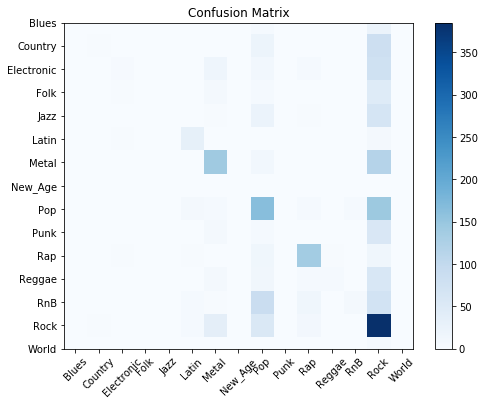

In [16]:
cm = confusion_matrix(y_test, y_pred)

### Confusion matrix
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.show()

## Hyperparameters tuning

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
clf2 = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = clf2, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, y_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
/Users/Bob/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
y_pred = rf_random.predict(X_test)
print(roc_auc_score((y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
print(rf_random.score(X_test,y_test))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

### Confusion matrix
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.show()

In [ ]:
Y_proba = clf.predict_proba(X)
print(Y_proba.shape)

In [ ]:
df_proba = pd.DataFrame(data = Y_proba, columns = class_names)

In [ ]:
print(train_idx,test_idx ,val_idx) 

In [ ]:
df_proba.describe()

In [ ]:
df_bow.describe()

In [43]:
df_final = df_bow.join(df_proba)

In [24]:
Y = rf_random.predict(X)


# Results on full data

In [25]:
Y_pred = Y
Y_true = le.transform(df_bow["genre"].values)
print(classification_report(Y_true, Y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Blues       1.00      0.64      0.78       186
     Country       0.98      0.78      0.87      1089
  Electronic       0.95      0.71      0.81       946
        Folk       1.00      0.74      0.85       575
        Jazz       0.99      0.59      0.74       451
       Latin       0.85      0.95      0.90       286
       Metal       0.90      0.82      0.86      2009
     New_Age       0.92      0.53      0.67        66
         Pop       0.81      0.83      0.82      2420
        Punk       1.00      0.68      0.81       546
         Rap       0.94      0.95      0.94      1347
      Reggae       0.99      0.77      0.87       595
         RnB       0.98      0.70      0.82       909
        Rock       0.63      0.94      0.76      3228
       World       0.97      0.71      0.82        97

    accuracy                           0.82     14750
   macro avg       0.93      0.76      0.82     14750
weighted avg       0.86   

In [8]:
label = df_bow['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print( y_classes.shape)
y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New_Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(14750,)


# Deep Classifier

In [52]:
label = df_bow['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print( y_classes.shape)
y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New_Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(14750,)


In [53]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
X_val, y_val = X[val_idx], y[val_idx]

In [54]:
nb_classes = len(le.classes_)
nb_features = len(X_train[0])
#X_train, X_test, X_val = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1), np.expand_dims(X_val, axis=-1)

In [55]:
X_train.shape, y_train.shape

((10340, 5000), (10340, 15))

In [155]:
model = Sequential()


model.add(Dense(32,input_dim=(nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 32)                160032    
_________________________________________________________________
batch_normalization_39 (Batc (None, 32)                128       
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)              

In [156]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))

Train on 10340 samples, validate on 2298 samples
Epoch 1/3
10340/10340 [==============================] - 3s 335us/step - loss: 2.6604 - accuracy: 0.2214 - val_loss: 2.3586 - val_accuracy: 0.3159
Epoch 2/3
10340/10340 [==============================] - 1s 117us/step - loss: 2.1274 - accuracy: 0.3670 - val_loss: 1.9676 - val_accuracy: 0.4025
Epoch 3/3
10340/10340 [==============================] - 1s 98us/step - loss: 1.9210 - accuracy: 0.4143 - val_loss: 1.9225 - val_accuracy: 0.4073


In [157]:
y_pred = model.predict(X_test)

In [158]:
y_pred = np.argmax(y_pred, axis =1)
y_pred = to_categorical(y_pred, num_classes=15)

In [159]:
len(y_pred[10])

15

In [160]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00        30
     Country       0.36      0.24      0.29       107
  Electronic       0.00      0.00      0.00       115
        Folk       0.00      0.00      0.00        64
        Jazz       0.00      0.00      0.00        96
       Latin       0.59      0.35      0.44        46
       Metal       0.49      0.65      0.56       275
     New_Age       0.00      0.00      0.00         2
         Pop       0.37      0.48      0.42       337
        Punk       0.00      0.00      0.00        75
         Rap       0.51      0.80      0.63       174
      Reggae       0.42      0.14      0.21        94
         RnB       0.53      0.16      0.25       191
        Rock       0.36      0.61      0.45       497
       World       0.00      0.00      0.00         9

   micro avg       0.41      0.41      0.41      2112
   macro avg       0.24      0.23      0.22      2112
weighted avg       0.35   

/Users/Bob/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
y_pred = model.predict(X)


In [168]:
y_pred = np.argmax(y_pred, axis =1)
y_pred =to_categorical(y_pred, num_classes=15)

In [169]:
print(classification_report(y, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00       186
     Country       0.55      0.34      0.42      1089
  Electronic       0.77      0.02      0.04       946
        Folk       0.80      0.01      0.01       575
        Jazz       0.00      0.00      0.00       451
       Latin       0.74      0.60      0.66       286
       Metal       0.58      0.72      0.65      2009
     New_Age       0.00      0.00      0.00        66
         Pop       0.49      0.59      0.54      2420
        Punk       0.00      0.00      0.00       546
         Rap       0.63      0.88      0.74      1347
      Reggae       0.57      0.17      0.26       595
         RnB       0.56      0.26      0.36       909
        Rock       0.38      0.71      0.50      3228
       World       0.00      0.00      0.00        97

   micro avg       0.49      0.49      0.49     14750
   macro avg       0.41      0.29      0.28     14750
weighted avg       0.50   

In [177]:
len(y_pred)

14750

In [178]:
y_pred = [y_pred[i] for i in range(len(y_pred))]

In [179]:
y_pred = le.inverse_transform(y_pred)


ValueError: bad input shape (14750, 15)

## Exporting

In [28]:
Y = le.inverse_transform(Y)
df_final["bow_genre"] = Y

NameError: name 'df_final' is not defined

In [55]:
df_final = df_final.drop("bow", axis = 1)

In [56]:
export_csv = df_final.to_csv (r'../data/bow_results.csv', index = None, header=True)